# 09 — Formal Evaluation

Compute Precision@K and NDCG@K for all 4 configurations.

**Precision@K** — fraction of Top-K recommendations matching the user's sector.

**NDCG@K** — same but position-aware: a relevant article at rank 1 is worth more than at rank 10.

K values tested: 5 and 10.

In [4]:
import sys
sys.path.append('../src')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from user_profile import SYNTHETIC_USERS
from evaluator import evaluate_all, summary_table

# Load recommendations saved by notebook 08
CONFIG_FILENAMES = {
    'W2V — no boost':        'recs_w2v_no_boost.csv',
    'W2V — recency boost':   'recs_w2v_boost.csv',
    'SBERT — no boost':      'recs_sbert_no_boost.csv',
    'SBERT — recency boost': 'recs_sbert_boost.csv',
}

all_recs = {}
for config_name, filename in CONFIG_FILENAMES.items():
    df = pd.read_csv(f'../data/processed/recommendations/{filename}')
    all_recs[config_name] = {
        user_id: group.drop(columns='user_id').reset_index(drop=True)
        for user_id, group in df.groupby('user_id')
    }

print('Loaded configs:', list(all_recs.keys()))
print('Users per config:', [len(v) for v in all_recs.values()])

Loaded configs: ['W2V — no boost', 'W2V — recency boost', 'SBERT — no boost', 'SBERT — recency boost']
Users per config: [4, 4, 4, 4]


## Step 1 — Restore user objects

In [5]:
import copy
from profile_builder import build_profile_vectors

reading_log = pd.read_csv('../data/processed/reading_log.csv')

# We need two sets — W2V users and SBERT users
# Profile vectors don't matter here, only sector labels are used for evaluation
users_w2v   = copy.deepcopy(SYNTHETIC_USERS)
users_sbert = copy.deepcopy(SYNTHETIC_USERS)

for user in users_w2v + users_sbert:
    user.clicked_articles = reading_log[
        reading_log['user_id'] == user.user_id
    ]['article_id'].tolist()

users_by_config = {
    'W2V — no boost':        users_w2v,
    'W2V — recency boost':   users_w2v,
    'SBERT — no boost':      users_sbert,
    'SBERT — recency boost': users_sbert,
}

print('Users ready')

Users ready


## Step 2 — Compute Precision@K and NDCG@K

In [6]:
print(all_recs['SBERT — no boost']['User_1'].head())

   rank  article_id                                           headline  \
0     1         269      ['KSE further up on buying in cement stocks']   
1     2        2269      ['KSE ends up cement, power stocks in focus']   
2     3        1168  ['KSE committees not yet formed', 'Share price...   
3     4        1115  ['KSE extraordinary general meeting adjourned ...   
4     5        3586  ['PPL, govt sign concession agreements', 'KSE ...   

    primary_tag  similarity  boost  final_score  
0  Construction    0.782182    0.0     0.782182  
1  Construction    0.767803    0.0     0.767803  
2         Other    0.754280    0.0     0.754280  
3         Other    0.752579    0.0     0.752579  
4        Energy    0.751302    0.0     0.751302  


In [7]:
df_eval = evaluate_all(
    all_recs=all_recs,
    users_by_config=users_by_config,
    k_values=[5, 10]
)

print('Full evaluation results:')
print(df_eval.to_string(index=False))

Full evaluation results:
               config user_id       sector  k  precision   ndcg
       W2V — no boost  User_1 Construction  5        0.0 0.0000
       W2V — no boost  User_1 Construction 10        0.0 0.0000
       W2V — no boost  User_2 Construction  5        0.0 0.0000
       W2V — no boost  User_2 Construction 10        0.0 0.0000
       W2V — no boost  User_3      Banking  5        1.0 1.0000
       W2V — no boost  User_3      Banking 10        1.0 1.0000
       W2V — no boost  User_4       Energy  5        0.6 0.6992
       W2V — no boost  User_4       Energy 10        0.6 0.9146
  W2V — recency boost  User_1 Construction  5        0.0 0.0000
  W2V — recency boost  User_1 Construction 10        0.0 0.0000
  W2V — recency boost  User_2 Construction  5        0.0 0.0000
  W2V — recency boost  User_2 Construction 10        0.0 0.0000
  W2V — recency boost  User_3      Banking  5        0.8 0.6608
  W2V — recency boost  User_3      Banking 10        0.9 0.8329
  W2V — recency

## Step 3 — Summary table

In [8]:
summary = summary_table(df_eval)
print('=== Mean Precision@K and NDCG@K per Configuration ===')
print(summary.to_string())

# Best config at K=10
at_10 = summary.xs(10, level='k')
print(f'\n→ Best Precision@10: {at_10["precision"].idxmax()} ({at_10["precision"].max()})')
print(f'→ Best NDCG@10:      {at_10["ndcg"].idxmax()} ({at_10["ndcg"].max()})')

=== Mean Precision@K and NDCG@K per Configuration ===
                          precision    ndcg
config                k                    
SBERT — no boost      5       0.650  0.8169
                      10      0.625  0.8810
SBERT — recency boost 5       0.500  0.5000
                      10      0.525  0.6627
W2V — no boost        5       0.400  0.4248
                      10      0.400  0.4786
W2V — recency boost   5       0.350  0.3459
                      10      0.350  0.4474

→ Best Precision@10: SBERT — no boost (0.625)
→ Best NDCG@10:      SBERT — no boost (0.881)


## Step 4 — Visualize

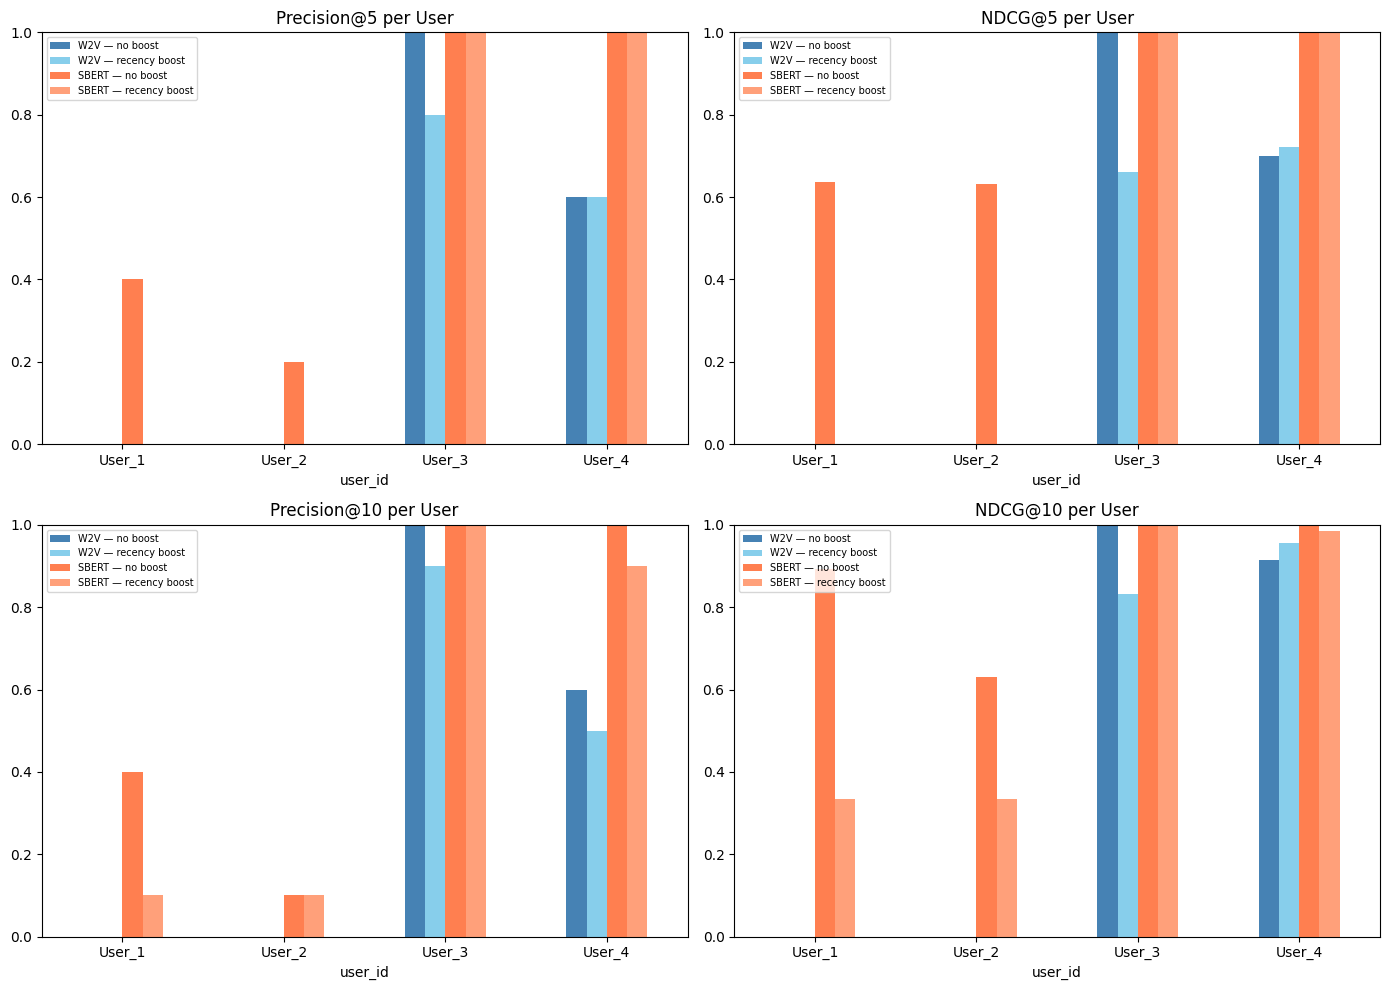

In [9]:
# Precision@K and NDCG@K side by side for K=5 and K=10
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

config_order = ['W2V — no boost','W2V — recency boost','SBERT — no boost','SBERT — recency boost']

for row, k in enumerate([5, 10]):
    subset = df_eval[df_eval['k'] == k]

    # Precision@K
    pivot_p = subset.pivot(index='user_id', columns='config', values='precision')[config_order]
    pivot_p.plot(kind='bar', ax=axes[row, 0],
                 title=f'Precision@{k} per User',
                 ylim=(0, 1), color=['steelblue','skyblue','coral','lightsalmon'])
    axes[row, 0].tick_params(axis='x', rotation=0)
    axes[row, 0].legend(fontsize=7)

    # NDCG@K
    pivot_n = subset.pivot(index='user_id', columns='config', values='ndcg')[config_order]
    pivot_n.plot(kind='bar', ax=axes[row, 1],
                 title=f'NDCG@{k} per User',
                 ylim=(0, 1), color=['steelblue','skyblue','coral','lightsalmon'])
    axes[row, 1].tick_params(axis='x', rotation=0)
    axes[row, 1].legend(fontsize=7)

plt.tight_layout()
plt.show()

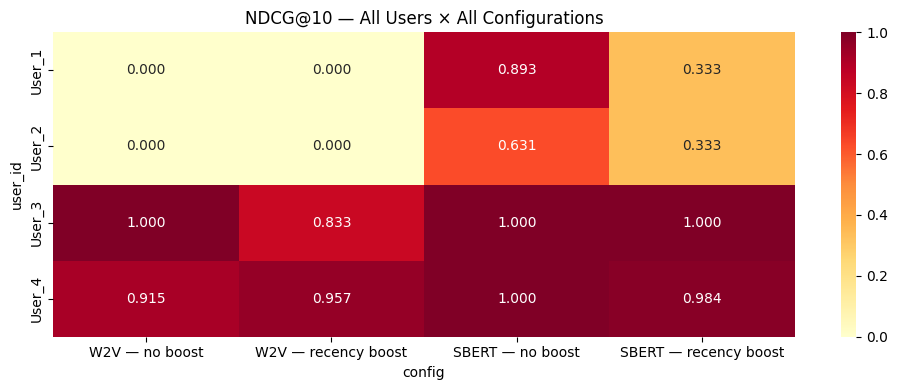

In [10]:
# Heatmap — NDCG@10 per user per config
ndcg_10 = df_eval[df_eval['k'] == 10].pivot(index='user_id', columns='config', values='ndcg')[config_order]

plt.figure(figsize=(10, 4))
sns.heatmap(ndcg_10, annot=True, fmt='.3f', cmap='YlOrRd', vmin=0, vmax=1)
plt.title('NDCG@10 — All Users × All Configurations')
plt.tight_layout()
plt.show()

In [11]:
# Save evaluation results
df_eval.to_csv('../data/processed/evaluation_results.csv', index=False)
print('Evaluation results saved to data/processed/evaluation_results.csv')

Evaluation results saved to data/processed/evaluation_results.csv


## Conclusions
- [ ] Best Precision@5: ...
- [ ] Best Precision@10: ...
- [ ] Best NDCG@5: ...
- [ ] Best NDCG@10: ...
- [ ] Construction users (User_1, User_2) performance: ...
- [ ] Banking/Energy users (User_3, User_4) performance: ...
- [ ] Overall best config: ...
- [ ] Ready for Streamlit (notebook 10 / app.py): yes/no